In [17]:
# import the library
import googlemaps
import configparser
from geopy.geocoders import Nominatim
import pandas as pd
import time

config = configparser.ConfigParser()
config.read('config.ini')

# Define the API Key.
API_KEY = config['GOOGLEMAPS_API']['API_KEY']
latitude = config['LOC']['LATITUDE']
longitude = config['LOC']['LONGITUDE']

# Initialize the geocoder
geolocator = Nominatim(user_agent="my_geocoder")

location = geolocator.geocode(f"{latitude} {longitude}")
latitude_dd = location.latitude
longitude_dd = location.longitude

print(f"Latitude in Decimal Degrees: {latitude_dd}")
print(f"Longitude in Decimal Degrees: {longitude_dd}")

# Define the Client
gmaps = googlemaps.Client(key = API_KEY)

Latitude in Decimal Degrees: 41.8932408
Longitude in Decimal Degrees: 12.482981487083691


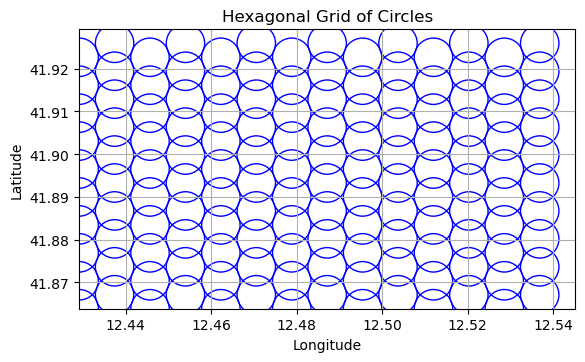

In [7]:
import math
import matplotlib.pyplot as plt

# Center point (latitude and longitude)
center_lat = latitude_dd  # Replace with your center latitude
center_lng = longitude_dd  # Replace with your center longitude

# Radius of the center circle in meters
radius_meters = 500  # 500 meters

# Calculate the horizontal and vertical spacing between circles in degrees
radius = (radius_meters / 1000) / 111.32 

# Number of rows and columns in the hexagonal grid
num_rows = 10
num_cols = 14

# Calculate the horizontal and vertical spacing between circles
h_spacing = 3/2 * radius * 1.23
v_spacing = math.sqrt(3) * radius * 0.84

# Calculate the coordinates of the top-left corner of the grid
x_min = center_lng - (num_cols - 1) * h_spacing / 2
y_min = center_lat - (num_rows - 1) * v_spacing / 2

# Create a figure and axis for plotting
fig, ax = plt.subplots()

locations = []
# Generate coordinates for the hexagonal grid of circles
for row in range(num_rows):
    for col in range(num_cols):
        # Calculate the coordinates for the center of each circle in the grid
        x = x_min + col * h_spacing
        y = y_min + row * v_spacing
        locations.append([x,y])
        # Offset every other row
        if col % 2 == 1:
            y += v_spacing / 2
        
        # Create a circle with the specified radius
        circle = plt.Circle((x, y), radius, fill=False, color='blue')
        
        # Add the circle to the plot
        ax.add_patch(circle)

# Set the aspect ratio to be equal (so circles look like circles)
ax.set_aspect('equal', adjustable='box')

# Calculate axis limits based on the grid's extent
x_max = x_min + num_cols * h_spacing 
y_max = y_min + num_rows * v_spacing

# Set the axis limits
ax.set_xlim(x_min , x_max)
ax.set_ylim(y_min , y_max)

with open('./output/loc.txt', 'w') as f:
    for loc in locations:
        f.write(f'{loc[0]},{loc[1]}\n')

# Show the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hexagonal Grid of Circles')
plt.grid(True)
plt.show()


In [28]:
stored_results = []
for location in locations:
    for page in range(1,4):
        if page == 1:
            places_result = gmaps.places_nearby(location=f'{location[1]},{location[0]}', radius = 500)
        else:
            try:
                places_result = gmaps.places_nearby(location=f'{location[1]},{location[0]}',radius = 500, page_token=places_result['next_page_token'])
            except:
                pass
        stored_results_temp = [result for result in places_result['results']]
        stored_results += stored_results_temp
        time.sleep(3)

In [29]:
print(len(stored_results))

8341


In [33]:
# Create an empty DataFrame
df = pd.DataFrame(columns=['place_id', 'name', 'lat', 'lng', 'types'])

# Iterate through the list and extract information
for place in stored_results:
    place_id = place['place_id']
    name = place['name']
    lat = place['geometry']['location']['lat']
    lng = place['geometry']['location']['lng']
    types = place['types']
    row = pd.DataFrame({'place_id': [place_id], 'name': [name], 'lat': [lat], 'lng': [lng], 'types': [types]})

    # Append the extracted information as a new row
    df = pd.concat([df, row], ignore_index=True)

# Print the resulting DataFrame
df = df.dropna(subset='place_id')
df = df.drop_duplicates(subset='place_id')
df

/var/folders/x1/2j32gjvd4v16s6kf306sfdcw0000gn/T/ipykernel_21075/3875331636.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row], ignore_index=True)


,place_id,name,lat,lng,types
0,ChIJu46S-ZZhLxMROG5lkwZ3D7k,Rome,41.902783,12.496365,"[locality, political]"
1,ChIJa20CeU_1JRMRY8r4Ycv0JD0,La Valle Dei Casali,41.862696,12.426711,"[lodging, point_of_interest, establishment]"
2,ChIJT0zleEX1JRMR1Gl4jbJaW6w,Il Baffetto,41.863067,12.426407,"[lodging, point_of_interest, establishment]"
3,ChIJPcS3zk31JRMRmfvcRACFk5s,Ristorante Casette di Campagna,41.862066,12.432911,"[restaurant, food, point_of_interest, establis..."
4,ChIJpYknxEhgLxMRyLvgx0ZEyqA,Varsi Art&Lab,41.863341,12.433148,"[art_gallery, point_of_interest, establishment]"
...,...,...,...,...,...
8336,ChIJO1s4DOZjLxMRqeax33qtKIQ,Mejo de Betto e Mary,41.925716,12.539891,"[restaurant, point_of_interest, food, establis..."
8337,ChIJXXEjBeZjLxMR8VDMEuxx8uw,Pietralata Legnami Srls,41.925249,12.540910,"[general_contractor, point_of_interest, establ..."
8338,ChIJIfwazllhLxMRVrz51gi97CE,Cafe Twin Royal Enfield Rome,41.925565,12.535299,"[car_repair, point_of_interest, store, establi..."
8339,ChIJD9obH-FjLxMR0I7Tr5wrzsM,Descor Srl,41.924443,12.534010,"[point_of_interest, establishment]"


In [31]:
df.to_csv(f'./output/places.csv')